# PROYEK REKOMENDASI FILM

- Nama: [Maklon Jaco Frare] <br>
- Email: [maklonjacob.frare@gmail.com] <br>
- ID Dicoding: [maklon]

# DATA LOADING

## Import Library

In [ ]:
import shutil
import os
import zipfile
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from ast import literal_eval
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score

import matplotlib.pyplot as plt
import missingno as msno
from wordcloud import WordCloud
%matplotlib inline

from google.colab import files
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.utils import shuffle
from scipy.sparse import csr_matrix  # Untuk struktur sparse
from sklearn.model_selection import train_test_split

## Download Dataset dan Extrak Dataset

Pada tahap, kita akan mengambil dataset dari luar (Kaggle) yakni Dataset The Movies Dataset yang diupload oleh
Rounak Banik. Datasetnya dapat dilihat pada [tautan ini](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset)

In [ ]:
#!kaggle datasets download -d rounakbanik/the-movies-dataset

Selanjutnya, kita akan mengekstrak file zip dan mengambil dataset dalam format csv

In [ ]:
#!unzip "the-movies-dataset.zip"

## Copy Dataset File to Drive

Pada tahap ini, kita akan menyalin file csv yang akan diolah. Pada proyek ini kita hanya menggunakan file `movies_metadata.csv` dan `rating.csv`. Langkah awal kita hubungankan colab ke drive kita dengan fungsi `mount`

In [ ]:
# impor library drive untuk salin data ke drive kita
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Selanjutnya, kita salin file `mivies_metadata.csv` dan `ratings.csv` dari folder content google colab ke folder MoviesDataset google drive kita

In [ ]:
#!cp {"/content/movies_metadata.csv"} {"/content/drive/MyDrive/Dataset/MoviesDataset"}
#!cp {"/content/ratings_small.csv"} {"/content/drive/MyDrive/Dataset/MoviesDataset"}
#!cp {"/content/ratings.csv"} {"/content/drive/MyDrive/Dataset/MoviesDataset"}
#!cp {"/content/credits.csv"} {"/content/drive/MyDrive/Dataset/MoviesDataset"}
#!cp {"/content/keywords.csv"} {"/content/drive/MyDrive/Dataset/MoviesDataset"}
#!cp {"/content/links.csv"} {"/content/drive/MyDrive/Dataset/MoviesDataset"}
#!cp {"/content/links_small.csv"} {"/content/drive/MyDrive/Dataset/MoviesDataset"}

## Reading Data

Pada tahap ini kita akan membaca dataset kita yang sudah tersalin pada drive kita

In [ ]:
# Path folder yang ingin dihitung
folder_path = "/content/drive/MyDrive/Dataset/MoviesDataset"

# Menghitung jumlah file di dalam folder
file_count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])

# Menghitung jumlah folder di dalam folder
folder_count = len([f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))])

print(f"Jumlah File Dataset Sebanyak: {file_count}")

Jumlah File Dataset Sebanyak: 7


In [ ]:
# menyimpan dataset dalam variabel
movies = pd.read_csv('/content/drive/MyDrive/Dataset/MoviesDataset/movies_metadata.csv', low_memory=False)
ratings = pd.read_csv('/content/drive/MyDrive/Dataset/MoviesDataset/ratings_small.csv', low_memory=False)
ratings_all = pd.read_csv('/content/drive/MyDrive/Dataset/MoviesDataset/ratings.csv', low_memory=False)
keywords = pd.read_csv('/content/drive/MyDrive/Dataset/MoviesDataset/keywords.csv', low_memory=False)
credits = pd.read_csv('/content/drive/MyDrive/Dataset/MoviesDataset/credits.csv', low_memory=False)
links = pd.read_csv('/content/drive/MyDrive/Dataset/MoviesDataset/links.csv', low_memory=False)
links_small = pd.read_csv('/content/drive/MyDrive/Dataset/MoviesDataset/links_small.csv', low_memory=False)

In [ ]:
print('----------------------------------------------------------------------------------------------------------------------')
print('Jumlah data film sebanyak: ', len(movies.id.unique()))
print('----------------------------------------------------------------------------------------------------------------------')
print('Jumlah data rating yang diberikan pengguna pada semua file rating (ratings.csv) sebanyak: ', len(ratings_all))
print('Jumlah data pengguna yang memberikan rating pada semua file rating (ratings.csv) sebanyak: ', len(ratings_all.userId.unique()))
print('Jumlah data film yang diberikan rating oleh pengguna pada semua file rating (ratings.csv) sebanyak: ', len(ratings_all.movieId.unique()))

print('----------------------------------------------------------------------------------------------------------------------')
print('Jumlah data rating pada sebagian file rating (ratings_small.csv) sebanyak: ', len(ratings))
print('Jumlah data pengguna yang memberikan rating pada sebagian file rating (ratings_all.csv) sebanyak: ', len(ratings.userId.unique()))
print('Jumlah data film yang diberikan rating oleh pengguna pada sebagian file rating (ratings_all.csv)  sebanyak: ', len(ratings.movieId.unique()))

print('----------------------------------------------------------------------------------------------------------------------')
print('Jumlah data kata kunci sebanyak: ',len(keywords.id.unique()))
print('----------------------------------------------------------------------------------------------------------------------')
print('Jumlah data pemeran dan kru untuk semua film sebanyak: ', len(credits.id.unique()))
print('----------------------------------------------------------------------------------------------------------------------')
print('Jumlah data ID TMDB dan IMDB dari semua film sebanyak: ', len(links.movieId.unique()))
print('----------------------------------------------------------------------------------------------------------------------')
print('Jumlah data ID TMDB dan IMDB dari sebagian kecil film dari Kumpulan Data Lengkap sebanyak: ', len(links_small.movieId.unique()))
print('----------------------------------------------------------------------------------------------------------------------')

----------------------------------------------------------------------------------------------------------------------
Jumlah data film sebanyak:  45436
----------------------------------------------------------------------------------------------------------------------
Jumlah data rating yang diberikan pengguna pada semua file rating (ratings.csv) sebanyak:  26024289
Jumlah data pengguna yang memberikan rating pada semua file rating (ratings.csv) sebanyak:  270896
Jumlah data film yang diberikan rating oleh pengguna pada semua file rating (ratings.csv) sebanyak:  45115
----------------------------------------------------------------------------------------------------------------------
Jumlah data rating pada sebagian file rating (ratings_small.csv) sebanyak:  100004
Jumlah data pengguna yang memberikan rating pada sebagian file rating (ratings_all.csv) sebanyak:  671
Jumlah data film yang diberikan rating oleh pengguna pada sebagian file rating (ratings_all.csv)  sebanyak:  9066
---

Berdasarkan varibel-variabel dataset di ataas, kita cukup mengambil variabel sesuai kebutuhan analisis dan pelatihan model pada proyek ini yakni movies dan rating.

# Exploratory Data Analysis (EDA)

## Univariate Analysis

Pada tahap ini kita akan melihat variabel dataset serta menggunakan grafik untuk menggambarkan distribusi genre dan rating film, serta hubungan antara fitur-fitur dalam dataset.

### Deskripsi Variabel

Pada langkah ini kita akan menampilkan informasi variabel ratings dan movies dengan fungsi `info`. Pertama kita mulai cek variabel ratings

In [ ]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


Berdasarkan gambar diatas, variabel ratings terdiri dari 100004 baris dan 4 kolom yang dapat dijelaskan sebagai berikut:

| Variabel                    | Keterangan     |
| -----------------------     | ------------------------------------------------------------------------- |
| userId                      | ID unik untuk pengguna yang memberikan penilaian (rating). Ini digunakan untuk mengidentifikasi pengguna secara anonim.  |
| movieId|ID unik untuk film yang dinilai oleh pengguna untuk mendapatkan informasi lebih detail tentang film tersebut.                                  |
| rating | Nilai yang diberikan oleh pengguna untuk film tertentu dengan skala 1 hingga 5, di mana angka yang lebih tinggi menunjukkan penilaian yang lebih positif. |
| timestamp                   | Waktu ketika penilaian diberikan, direpresentasikan dalam format UNIX timestamp (jumlah detik sejak 1 Januari 1970).   |

Kedua kita cek variabel movies

In [ ]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

Berdasarkan gambar diatas, variabel movies terdiri dari 100004 baris dan 24 kolom yang dapat dijelaskan sebagai berikut:

| Variabel                    | Keterangan     |
| -----------------------     | ------------------------------------------------------------------------- |
|adult        | Mengindikasikan apakah film tersebut untuk orang dewasa (adult content). Nilainya biasanya True atau False.|
|belongs_to_collection|Informasi tentang koleksi atau seri film tertentu yang mencakup film ini (misalnya, film dalam seri Harry Potter). Biasanya berupa JSON atau string deskriptif.|
|Budget|Anggaran produksi film dalam satuan mata uang (biasanya USD). Nilainya berupa angka.|
|genres|Daftar genre film, seperti Action, Comedy, Drama. Biasanya berupa JSON atau daftar string.|
|homepage|URL dari situs web resmi film tersebut.|
|id|ID unik untuk film, biasanya merujuk pada database film tertentu seperti TMDb.|
|imdb_id|ID unik dari film di IMDb (misalnya, tt1234567).|
|original_language|Bahasa asli film tersebut dalam format kode bahasa ISO 639-1 (misalnya, en untuk bahasa Inggris).|
|original_title|Judul asli film dalam bahasa produksinya.|
|overview|Judul asli film dalam bahasa produksinya.|
|popularity|Skor popularitas film berdasarkan sistem tertentu, sering dihitung menggunakan algoritma dari platform film.|
|poster_path|Path atau tautan menuju gambar poster film. Biasanya berupa path yang dapat digabungkan dengan URL dasar untuk akses.|
|production_companies|Informasi tentang perusahaan produksi film tersebut. Biasanya berupa JSON dengan nama dan ID perusahaan.|
|production_countries|Negara tempat film tersebut diproduksi. Biasanya berupa JSON dengan nama negara dan kode negara.|
|release_date|Tanggal rilis film (format: YYYY-MM-DD).|
|revenue|Pendapatan kotor yang diperoleh film (biasanya dalam USD).|
|runtime|Durasi film dalam menit.|
|spoken_languages|Bahasa yang digunakan dalam dialog film. Biasanya berupa JSON dengan nama dan kode bahasa.|
|status|Status rilis film (misalnya, Released, In Production).|
|tagline|Slogan atau frasa singkat yang biasanya digunakan untuk promosi film.|
|title|Judul utama film yang digunakan untuk promosi.|
|video|Mengindikasikan apakah ada video terkait film. Nilainya biasanya berupa True atau False.|
|vote_average|Nilai rata-rata yang diberikan oleh pengguna (misalnya dari IMDb atau TMDb) berdasarkan skala tertentu (biasanya 1-10).|
|vote_count|Jumlah suara atau ulasan yang diberikan untuk film tersebut.|

Kedua gambar diatas merupakan informasi variabel movies dan rating dataset kita.

### Melihat Infromasi Tipe Data

Pada tahap ini, kita akan melihat informasi pada dataset *ratings* dan *movies*

In [ ]:
tipe_data_movies = movies.dtypes.value_counts()
tipe_data_movies

,count
object,20
float64,4


In [ ]:
tipe_data_ratings = ratings.dtypes.value_counts()
tipe_data_ratings

,count
int64,3
float64,1


Dapat dilihat pada informasi dataset **movies** 20 variable dengan tipe data object dan 4 variabel bertipe float64. Sedangkan pada informasi dataset **ratings** terdapat 1 variabel dengan tipe data float64 dan 3 variable dengan tipe data int64.

### Menghitung Total Dataset

Pertama, kita akan melihat total dataset `ratings` dan `movies`

In [ ]:
rows_movie = movies.shape[0]
cols_movie = movies.shape[1]
rows_rating = ratings.shape[0]
cols_rating = ratings.shape[1]

print(f'Jumlah data Movie sebanyak {rows_movie}, dan memiliki {cols_movie} kolom')
print(f'Jumlah data Rating sebanyak {rows_rating}, dan memiliki {cols_rating} kolom')


Jumlah data Movie sebanyak 45466, dan memiliki 24 kolom
Jumlah data Rating sebanyak 100004, dan memiliki 4 kolom


### Menghitung Total Data Unik

In [ ]:
print(f"Jumlah film unik pada dataset movies : {movies['id'].nunique()}")
print(f"Jumlah film unik pada dataset ratings: {ratings['movieId'].nunique()}")
print(f"Jumlah user unik pada dataset ratings: {ratings['userId'].nunique()}")


Jumlah film unik pada dataset movies : 45436
Jumlah film unik pada dataset ratings: 9066
Jumlah user unik pada dataset ratings: 671


Dari hasil diatas terdapat 45436 film pada dataset movies, 9066 film pada dataset ratings dan 671 user pada dataset ratings

### Melihat Data Deskriptif pada variabel dataset

In [ ]:
movies.describe()

,revenue,runtime,vote_average,vote_count
count,4.546000e+04,45203.000000,45460.000000,45460.000000
mean,1.120935e+07,94.128199,5.618207,109.897338
std,6.433225e+07,38.407810,1.924216,491.310374
min,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000e+00,85.000000,5.000000,3.000000
50%,0.000000e+00,95.000000,6.000000,10.000000
75%,0.000000e+00,107.000000,6.800000,34.000000
max,2.787965e+09,1256.000000,10.000000,14075.000000


In [ ]:
ratings.describe()

,userId,movieId,rating,timestamp
count,100004.000000,100004.000000,100004.000000,1.000040e+05
mean,347.011310,12548.664363,3.543608,1.129639e+09
std,195.163838,26369.198969,1.058064,1.916858e+08
min,1.000000,1.000000,0.500000,7.896520e+08
25%,182.000000,1028.000000,3.000000,9.658478e+08
50%,367.000000,2406.500000,4.000000,1.110422e+09
75%,520.000000,5418.000000,4.000000,1.296192e+09
max,671.000000,163949.000000,5.000000,1.476641e+09


Berdasarkan tampilan deskriptif dataset movies dan ratings dapat dilihat tidak mencolok ada pesebaran nilai yang menimbulkan `outlier`

### Distribusi Ratings

Pada langkah ini kita akan mendistribusi ratings dengan tujuan:
1. Mengidentifikasi nilai rating yang paling umum diberikan oleh pengguna.
2. Menilai apakah data rating cenderung condong ke satu nilai (misalnya, lebih banyak rating tinggi atau rendah).
3. Membantu memahami pola preferensi pengguna.

Text(0.5, 1.0, 'Presentasi rating')

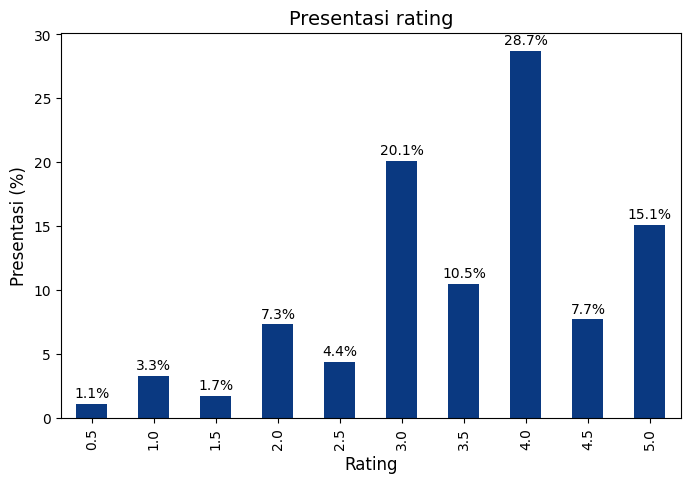

In [ ]:
#Mengelompokkan data berdasarkan kolom rating dan menghitung jumlah baris (count) untuk setiap nilai rating
count_rates = ratings.groupby('rating').count()

#Menghitung persentase jumlah rating tertentu terhadap total jumlah rating.
count_rates['percents_total']=round(count_rates['userId']*100/count_rates['userId'].sum(),1)

# Memvisualisasikan kolom perc_total dalam bentuk diagram batang menggunakan fungsi plot.bar()
# Membuat diagram batang
ax = count_rates['percents_total'].plot.bar(color='#0A3981', figsize=(8, 5))

# Menambahkan label persentase pada batang
for index, value in enumerate(count_rates['percents_total']):
    plt.text(index, value + 0.5, f'{value}%', ha='center', fontsize=10)

# Memberikan label pada sumbu
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Presentasi (%)', fontsize=12)
plt.title('Presentasi rating', fontsize=14)

Berdasarkan diagram plot rating diatas, dapat dilihat bahwa nilai ratings paling umum diberikan pengguna adalah rating 4.0 dengan presentasi 28.7%, rating 3.0 dengan presentasi 20.1%, rating 5.0 dengan prestansi 15.1%. Sedangkan nilai rating yang lain berada dibawah pada presentasi 12.0%

### Distribusi Genres

Pada tahap ini kita akan membersihkan, memproses, dan menormalkan data dalam kolom genres pada DataFrame df_movies. Ada beberapa fungsi yang kita pakai yakni:
* `fillna('[]')`, berfungsi untuk mengisi nilai`null` atau `NaN` dalam kolom genres dengan string kosong dalam format `list` ('[]').
* `apply(literal_eval)`, fungsi `literal_eval` dari pustaka `ast` untuk mengubah string yang terlihat seperti Python literal menjadi tipe data `list`.
* `apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else []`,
fungsi lambda ini memproses setiap nilai dalam kolom genres:
Jika nilai adalah sebuah daftar `(isinstance(x, list))`, maka ambil nilai dari kunci `name` untuk setiap elemen. Jika nilai bukan daftar, mengembalikan daftar kosong (`[]`).

Langkah pertama kita buat variabel dataframe baru untuk melakukan analisis visualisasi data. Kemudian kita konversi fitur(variabel) genres ke dalam bentuk list sehingga dapat dianalisis.

In [ ]:
df_analisis_movies = movies.copy()
df_analisis_movies['genres'] = df_analisis_movies['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

Selanjutanya kita ubah setiap elemen dalam daftar (genre) menjadi baris terpisah dengan fungsi `explode()`, kemudian menghitung jumlah kemunculan setiap genre dengan fungsi `value_counts()` dan terakhir  kita membuat diagram batang untuk menampilkan distribusi genre dengan plot bar `plot(kind='bar')`.

Distribusi Genre:
genres
Drama                                    20265
Comedy                                   13182
Thriller                                  7624
Romance                                   6735
Action                                    6596
Horror                                    4673
Crime                                     4307
Documentary                               3932
Adventure                                 3496
Science Fiction                           3049
Family                                    2770
Mystery                                   2467
Fantasy                                   2313
Animation                                 1935
Foreign                                   1622
Music                                     1598
History                                   1398
War                                       1323
Western                                   1042
TV Movie                                   767
Carousel Productions               

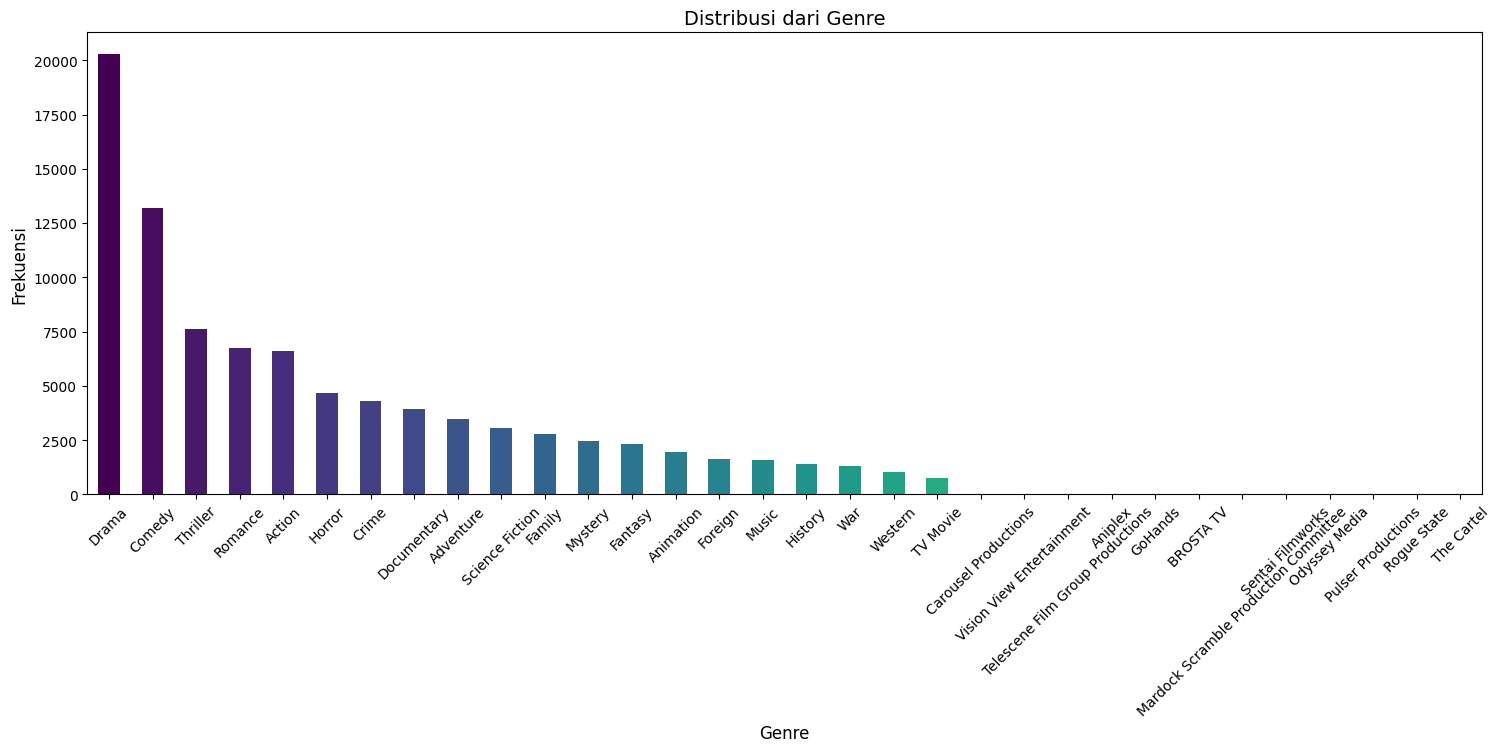

In [ ]:
# Menghitung distribusi genre
all_genres = df_analisis_movies['genres'].explode()  # Mengubah elemen dalam list menjadi baris terpisah
genre_counts = all_genres.value_counts()  # Menghitung jumlah tiap genre

# Menampilkan hasil distribusi
print("Distribusi Genre:")
print(genre_counts)

# Gradasi warna dengan cmap
colors = plt.cm.viridis(np.linspace(0, 1, len(genre_counts)))

# Plot distribusi genre
plt.figure(figsize=(18, 6))
genre_counts.plot(kind='bar', color=colors)
plt.title('Distribusi dari Genre', fontsize=14)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Frekuensi', fontsize=12)
plt.xticks(rotation=45)
plt.show()

Dari grafik diatas, dapat dilihat bahwa genre Drama dan Comedy paling banyak tersebar pada setiap film dalam dataset dengan jumah sebesar 20265 dan 13182. Sedangkan genre yang lain berada dibawah 10000. Terlihat juga ada 12 genre dengan jumlah 1.

### Analisis Daftar film dengan skor tertinggi di seluruh rentang film

Untuk membuat daftar film dengan skor tertinggi menggunakan metode `Weighted Score`. Metode ini merupakan perhitungan skor berbobot untuk menggabungkan nilai-nilai yang berbeda berdasarkan pentingnya masing-masing komponen. Dalam konteks film, kita perlu menghitung skor berbobot berdasarkan informasi yang tersedia, seperti rata-rata penilaian (`vote_average`), jumlah suara (`vote_count`), dan jumlah suara rata-rata minimum yang diperlukan untuk dipertimbangkan dalam daftar.
Keterangan:
* v = jumlah suara untuk film tertentu (`vote_count`)
* m = jumlah suara minimum untuk masuk ke daftar (`threshold`)
* R = rata-rata skor film tersebut (`vote_average`)
* C = rata-rata skor semua film dalam dataset (`rata-rata global`)

In [ ]:
# Menghitung nilai rata-rata
C = df_analisis_movies['vote_average'].mean()
R = df_analisis_movies['vote_average']
v = df_analisis_movies['vote_count']

# Menentukan nilai m (threshold vote_count minimum)
m = df_analisis_movies['vote_count'].quantile(0.75)  # Mengambil persentil ke-75 sebagai threshold

# Menghitung Weighted Score
df_analisis_movies['weighted_score'] = (v / (v + m) * R) + (m / (v + m) * C)

# Menyortir berdasarkan Weighted Score
top_movies = df_analisis_movies.sort_values('weighted_score', ascending=False)

# Menampilkan hasil
print("Daftar 5 Film dengan Skor Tertinggi:")
#top_movies.head(5)
top_movies[['id', 'genres', 'title', 'vote_average', 'vote_count', 'weighted_score']].head(5)


Daftar 5 Film dengan Skor Tertinggi:


,id,genres,title,vote_average,vote_count,weighted_score
10309,19404,"[Comedy, Drama, Romance]",Dilwale Dulhania Le Jayenge,9.1,661.0,8.929668
314,278,"[Drama, Crime]",The Shawshank Redemption,8.5,8358.0,8.488324
834,238,"[Drama, Crime]",The Godfather,8.5,6024.0,8.483826
40251,372058,"[Romance, Animation, Drama]",Your Name.,8.5,1030.0,8.407913
12481,155,"[Drama, Action, Crime, Thriller]",The Dark Knight,8.3,12269.0,8.292589


Hasil Daftar tabel diatas menunjukan 5 filim dengan skor tertinggi yang diberikan oleh pengguna.

### Melakukan Analisis Rating Tertinggi

Selanjutnya kita gabungkan dataset df_movies dan ratings dengan fungsi pandas `pd.merge` dan mencari 10 film dengan rating tertinggi.

In [ ]:
# membuat salinan varibael dataset untuk proses analisis
movies_copy = movies.copy()
# Identifikasi dan tangani nilai tidak valid
movies_copy = movies_copy[movies['id'].apply(lambda x: str(x).isnumeric())]

# Konversi ke tipe int64
movies_copy['id'] = movies_copy['id'].astype('int64')
# df_movies.head()

movies_copy.rename(columns={'id': 'movieId'}, inplace=True)

df_movies = movies_copy.copy()

rating_movies = pd.merge(ratings, df_movies, on='movieId', how='inner')
rating_movies.drop(['timestamp','genres'],axis=1, inplace=True)

df_analisis_rating = pd.DataFrame(rating_movies.groupby('title')['rating'].mean())
df_analisis_rating['total ratings'] = pd.DataFrame(rating_movies.groupby('title')['rating'].count())
df_analisis_rating.rename(columns = {'rating': 'mean ratings'}, inplace=True)

df_analisis_rating.sort_values('total ratings', ascending=False).head(10)

<ipython-input-21-3f5f448a8240>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_copy['id'] = movies_copy['id'].astype('int64')
<ipython-input-21-3f5f448a8240>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_copy.rename(columns={'id': 'movieId'}, inplace=True)


,mean ratings,total ratings
title,,
Terminator 3: Rise of the Machines,4.256173,324
The Million Dollar Hotel,4.487138,311
Solaris,4.134426,305
The 39 Steps,4.221649,291
Monsoon Wedding,3.706204,274
Once Were Warriors,4.303279,244
Three Colors: Red,3.945175,228
Men in Black II,4.256696,224
The Passion of Joan of Arc,3.483945,218


Dapat dilihat dari 10 rating tertinggi film yang ada, film dengan judul Terminator 3: Rise of the Machines memiliki rating teratas dengan *mean rating* 4.256 dan total rating sebanyak 324.

### Membandingkan Peringkat rata-rata dan Jumlah total peringkat

Pada tahap ini kita akan membandingkan rata-rata rangkin dan total rangking menggunakan `joinplot` untuk melihat pesebaran data.

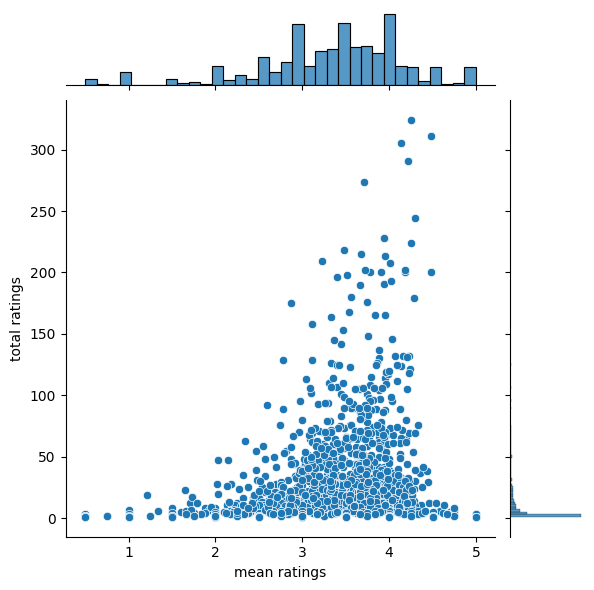

In [ ]:
sns.jointplot(x = 'mean ratings', y = 'total ratings', data = df_analisis_rating )

Berdasarkan grafik pesebaran data diatas total rating terting berada diatas 250 sebanyak 5 film, sadangkan rata-rata terbanyak pengguna memberi rating terhadap film berada diretang nilai 2 - 4.5 rating.

# DATA PREPARATION

## Data Clean
Proses ini bertujuan untuk menyiapkan data mentah agar dapat digunakan secara efektif dalam model machine learning. Setelah data terkumpul ada beberapa langkah yang perlu lakukan dalam tahap ini yaitu:

### Mengambil Fitur Sesuai Kebutuhan

Pada tahap ini, kita hanya mengambil beberapa fitur atau kolom dari variabel movies sesuai kebutuhan analsis pengolahan data yakni `['id', 'genres', 'title', 'vote_average', 'vote_count']`. Kemudian kita simpan pada variabel df_movies.

In [ ]:
# Pilih kolom yang diinginkan
selected_features_movies = ['id', 'genres', 'title', 'vote_average', 'vote_count']
# Buat DataFrame baru
df_movies = movies[selected_features_movies]
df_movies.head()

,id,genres,title,vote_average,vote_count
0,862,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",Toy Story,7.7,5415.0
1,8844,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",Jumanji,6.9,2413.0
2,15602,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",Grumpier Old Men,6.5,92.0
3,31357,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",Waiting to Exhale,6.1,34.0
4,11862,"[{'id': 35, 'name': 'Comedy'}]",Father of the Bride Part II,5.7,173.0


### Menyesuaikan Tipe Data Primary Key dan Foregein Key

Jika dilihat pada informasi sebelumnya, dataset movies atribut id (`primary key`) dengan type data `object` berbeda pada dataset ratings atribut movieId dengan type data `int64`. Oleh karena itu,kita perlu menyamakan tipe data tersebut dengan cara mnyamakan nama atribut movieId dan tipe data `int64`.

In [ ]:
df_movies_copy = df_movies.copy()
# Identifikasi dan tangani nilai tidak valid
df_movies_copy = df_movies_copy[df_movies['id'].apply(lambda x: str(x).isnumeric())]

# Konversi ke tipe int64
df_movies_copy['id'] = df_movies_copy['id'].astype('int64')
# df_movies.head()

df_movies_copy.rename(columns={'id': 'movieId'}, inplace=True)

df_movies = df_movies_copy.copy()
# Mengubah nama kolom dari 'id' menjadi 'movieId'
#df_movies.rename(columns={'id': 'movieId'}, inplace=True)

### Menangani Nilai Kosong (Missing Value)

Pada tap ini kita akan lakukan pengecekan nilai kosong pada variabel dataset df_movies dan ratings

In [ ]:
df_movies.isnull().sum()

,0
movieId,0
genres,0
title,3
vote_average,3
vote_count,3


Dari hasil diatas, nilai null terdapat pada variabel `title`, `vote_average` dan `vote_count` memiliki nilai null = 3.

In [ ]:
# Menampilkan baris yang memiliki nilai null
df_movies[df_movies.isnull().any(axis = 1)]

,movieId,genres,title,vote_average,vote_count
19729,82663,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,NaN,NaN
29502,122662,"[{'id': 16, 'name': 'Animation'}, {'id': 878, ...",NaN,NaN,NaN
35586,249260,"[{'id': 10770, 'name': 'TV Movie'}, {'id': 28,...",NaN,NaN,NaN


Dapat dilihat hasilnya terdapat beberap nilai kosong pada variabel dataset df_movies

In [ ]:
df_movies = df_movies.dropna(subset=['title', 'vote_average', 'vote_count'])
df_movies.isnull().sum()

,0
movieId,0
genres,0
title,0
vote_average,0
vote_count,0


In [ ]:
ratings.isnull().sum()

,0
userId,0
movieId,0
rating,0
timestamp,0


### Melihat Duplikat Data

Langkah pertama kita cek variabel dataset df_movies

In [ ]:
df_movies.duplicated().sum()
#df_movies.head()

28

Selanjutnya kita tampilkan movies yang duplikat

In [ ]:
# Menampilkan movies duplikat
df_movies[df_movies.duplicated]

,movieId,genres,title,vote_average,vote_count
1465,105045,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",The Promise,5.0,1.0
9165,5511,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",Le Samouraï,7.9,187.0
9327,23305,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",The Warrior,6.3,15.0
12066,14788,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",Bubble,6.4,36.0
13375,141971,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",Blackout,6.7,3.0
15074,22649,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",A Farewell to Arms,6.2,29.0
15765,13209,"[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name...",Offside,6.7,27.0
16764,141971,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",Blackout,6.7,3.0
20843,77221,"[{'id': 12, 'name': 'Adventure'}, {'id': 18, '...",Black Gold,5.9,77.0
20899,109962,"[{'id': 18, 'name': 'Drama'}]",Rich and Famous,4.9,7.0


Dari hasil di atas, terlihat bahwa ada data-data tersebut memang terduplikasi.

In [ ]:
df_movies.drop_duplicates(inplace = True)

Kedua kita cek dataset ratings yang duplikat

In [ ]:
ratings.duplicated().sum()

0

Hasil yang ditampilkan yakni 0 maka tidak ada duplikat data pada dataset ratings

## Data Preprocesing
Proses ini bertujuan untuk menyiapkan data mentah agar dapat digunakan secara efektif dalam model machine learning. Langkah-langkah yang dilakukan dalam proyak ini adalah sebagai berikut:
* Mengurutkan pengguna dan film berdasarkan id
* Mengubah fitur genres movie ke bentuk list
* Melakukan penggabungan dataset ratings dan movies
* Menghapus fitur yang tidak diperlukan
* Mengambil Dataset sesuai kebutuhan

### Mengurutkan pengguna berdasarkan ID

In [ ]:
ratings   = ratings.sort_values('userId')
df_movies = df_movies.sort_values('movieId')

In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
12,1,1953,4.0,1260759191
13,1,2105,4.0,1260759139
14,1,2150,3.0,1260759194


In [ ]:
df_movies.head()

,movieId,genres,title,vote_average,vote_count
4342,2,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",Ariel,7.1,44.0
12947,3,"[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name...",Shadows in Paradise,7.1,35.0
17,5,"[{'id': 80, 'name': 'Crime'}, {'id': 35, 'name...",Four Rooms,6.5,539.0
474,6,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",Judgment Night,6.4,79.0
256,11,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",Star Wars,8.1,6778.0


### Mengubah fitur genres movie ke bentuk list

In [ ]:
df_movies['genres'] = df_movies['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
df_movies['genres']

,genres
4342,"[Drama, Crime]"
12947,"[Drama, Comedy]"
17,"[Crime, Comedy]"
474,"[Action, Thriller, Crime]"
256,"[Adventure, Action, Science Fiction]"
...,...
45078,"[Fantasy, Drama]"
45273,[Drama]
21891,"[Drama, Romance]"
45398,"[Romance, Comedy]"


### Melakukan penggabungan Data

Pada tahap ini kita akan mengabungkan dataset ratings dan dataset movies menggunakan fungsi `merge` dan mengahapus variabel `timestamp` yang dibutuhkan.

In [ ]:
df_movies_ratings = pd.merge(ratings, df_movies, on='movieId', how='inner')
df_movies_ratings.head()

,userId,movieId,rating,timestamp,genres,title,vote_average,vote_count
0,1,2105,4.0,1260759139,"[Comedy, Romance]",American Pie,6.4,2358.0
1,1,2193,2.0,1260759198,"[Comedy, Drama, Romance]",My Tutor,5.8,17.0
2,1,2294,2.0,1260759108,[Comedy],Jay and Silent Bob Strike Back,6.4,491.0
3,1,2455,2.5,1260759113,"[Drama, Comedy, Crime]",Confidentially Yours,7.1,25.0
4,1,1371,2.5,1260759135,[Drama],Rocky III,6.6,894.0


### Menghapus fitur yang tidak diperlukan

Selanjutnya, menghapus fitur-firur yang tidak diperlukan yaitu `timestamp`, `vote_average` dan `vote_count`.

In [ ]:
df_movies_ratings.drop(['timestamp', 'vote_average', 'vote_count'],axis=1, inplace=True)

Selanjutnya gunakan fungsi `head` untuk melihat hasilnya.

In [ ]:
df_movies_ratings.head(10)

,userId,movieId,rating,genres,title
0,1,2105,4.0,"[Comedy, Romance]",American Pie
1,1,2193,2.0,"[Comedy, Drama, Romance]",My Tutor
2,1,2294,2.0,[Comedy],Jay and Silent Bob Strike Back
3,1,2455,2.5,"[Drama, Comedy, Crime]",Confidentially Yours
4,1,1371,2.5,[Drama],Rocky III
5,1,1405,1.0,"[Drama, History]",Greed
6,2,168,3.0,"[Science Fiction, Adventure]",Star Trek IV: The Voyage Home
7,2,165,3.0,"[Adventure, Comedy, Family, Science Fiction]",Back to the Future Part II
8,2,161,3.0,"[Thriller, Crime]",Ocean's Eleven
9,2,153,4.0,[Drama],Lost in Translation


### Mengambil Dataset sesuai kebutuhan

Pada tahap ini, kita mengambil 20000 gabugan dataset movies dan ratings dengan teknik sampling menggunakan fungsi `shuffle` dari library `sklearn.utils` untuk mengambil data secara acak dataset besar untuk mempermudah pengolahan dan mencegah **crash**.

In [ ]:
df_sample_final = shuffle(df_movies_ratings).head(20000)
df_sample_final

,userId,movieId,rating,genres,title
16328,258,3479,3.0,"[Thriller, Crime]",Dirty Hands
240,5,586,4.0,"[Comedy, Drama]",Wag the Dog
13251,212,8371,4.0,[Drama],Guter Junge
30595,472,920,4.5,"[Animation, Adventure, Comedy, Family]",Cars
17173,275,4995,4.5,[Drama],Boogie Nights
...,...,...,...,...,...
5400,78,4369,4.5,"[Drama, Romance]",Just a Question of Love
28375,452,2094,2.5,"[Drama, Music, Romance]",Roustabout
33435,518,377,4.0,[Horror],A Nightmare on Elm Street
16698,265,3089,4.0,[Western],Red River


# Content Based Filtering (CBF)

Content-Based Filtering adalah metode dalam sistem rekomendasi yang memberikan rekomendasi berdasarkan karakteristik atau konten dari item yang telah disukai atau dinilai oleh pengguna.

## A. Data Preparation

Teknik yang digunakan yaitu teknik TF-IDF (Term Frequency-Inverse Document Frequency) untuk menentukan bobot fitur dan menghitung kesamaan antara item. Pada proyek ini item yang aka kita gunaka yaitu `genres` film.

Langkah yang pertama kita cek datset kita sesuai dengan kebutuhan yang kita inginkan dengan fungsi `info()`

In [ ]:
df_sample_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 16328 to 24308
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   userId   20000 non-null  int64  
 1   movieId  20000 non-null  int64  
 2   rating   20000 non-null  float64
 3   genres   20000 non-null  object 
 4   title    20000 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 937.5+ KB


Dapa dilihat hasil informasi dataset kita terdiri dari 20000 baris dan 5 kolom dengan 1 tipe data float64, 2 tipe data int64 dan 2 tipe data object.

Berikutnya, kita bisa melanjutkan ke tahap persiapan dengan membuat variabel preparation yang berisi dataframe df_sample_final kemudian mengurutkan berdasarkan `movieId`

In [ ]:
preparation = df_sample_final
preparation.sort_values('movieId')

,userId,movieId,rating,genres,title
4350,69,2,3.5,"[Drama, Crime]",Ariel
11268,177,2,5.0,"[Drama, Crime]",Ariel
4647,73,2,2.5,"[Drama, Crime]",Ariel
2687,32,2,4.0,"[Drama, Crime]",Ariel
20364,313,2,3.0,"[Drama, Crime]",Ariel
...,...,...,...,...,...
613,15,140174,4.0,"[Action, Horror, Thriller]",Rise of the Zombies
31395,486,140174,3.5,"[Action, Horror, Thriller]",Rise of the Zombies
25282,402,148652,2.5,[Thriller],The Eleventh Victim
586,15,158238,3.5,[],Stolen Seas


In [ ]:
# Membuang data duplikat pada variabel preparation
preparation = preparation.drop_duplicates('movieId')
preparation

,userId,movieId,rating,genres,title
16328,258,3479,3.0,"[Thriller, Crime]",Dirty Hands
240,5,586,4.0,"[Comedy, Drama]",Wag the Dog
13251,212,8371,4.0,[Drama],Guter Junge
30595,472,920,4.5,"[Animation, Adventure, Comedy, Family]",Cars
17173,275,4995,4.5,[Drama],Boogie Nights
...,...,...,...,...,...
37482,564,3574,1.0,"[Thriller, Horror]",Doctor X
37481,564,3576,5.0,"[Drama, Thriller]",Calling Dr. Gillespie
35579,547,26467,1.0,[Action],The Climb
10172,157,80350,0.5,"[Thriller, Action, Drama]",Tough and Deadly


Selanjutnya, kita perlu melakukan konversi data series menjadi list. Dalam hal ini, kita menggunakan fungsi `tolist()` dari library numpy.

In [ ]:
# Mengonversi data series 'movieId' menjadi dalam bentuk list
movie_id = preparation['movieId'].tolist()

# Mengonversi data series ‘Title’ menjadi dalam bentuk list
movie_name = preparation['title'].tolist()

# Mengonversi data series ‘Genres’ menjadi dalam bentuk list
movie_genres = preparation['genres'].tolist()

print(len(movie_id))
print(len(movie_name))
print(len(movie_genres))

2249
2249
2249


Tahap berikutnya, kita akan membuat dictionary untuk menentukan pasangan key-value pada data `movie_id`, `movie_name` dan `movie_genres` yang telah kita siapkan sebelumnya.

In [ ]:
# Membuat dictionary untuk data ‘movie_id’, ‘movie_name’, dan genres
movies_new = pd.DataFrame({
    'id': movie_id,
    'movie_name': movie_name,
    'genres': movie_genres
})
movies_new

,id,movie_name,genres
0,3479,Dirty Hands,"[Thriller, Crime]"
1,586,Wag the Dog,"[Comedy, Drama]"
2,8371,Guter Junge,[Drama]
3,920,Cars,"[Animation, Adventure, Comedy, Family]"
4,4995,Boogie Nights,[Drama]
...,...,...,...
2244,3574,Doctor X,"[Thriller, Horror]"
2245,3576,Calling Dr. Gillespie,"[Drama, Thriller]"
2246,26467,The Climb,[Action]
2247,80350,Tough and Deadly,"[Thriller, Action, Drama]"


Selanjutnya langkah berikut kita gunakan fungsi `TfidfVectorizer` untuk mengkonversi `genres`. Namusn sebelum itu `genres` perlu kita konversi dari list ke siting akar dapay diproses.

In [ ]:
data = movies_new
# Mengonversi list menjadi string dengan pengecekan tipe data
data['genres'] = data['genres'].apply(lambda x: ', '.join(x) if isinstance(x, list) else '')

In [ ]:
# Inisialisasi TfidfVectorizer
tf_cbf = TfidfVectorizer()

# Melakukan perhitungan idf pada data track_genre
tf_cbf.fit(data["genres"])

# Mapping array dari fitur index integer ke fitur nama
tf_cbf.get_feature_names_out()

array(['action', 'adventure', 'animation', 'comedy', 'crime',
       'documentary', 'drama', 'family', 'fantasy', 'fiction', 'foreign',
       'history', 'horror', 'movie', 'music', 'mystery', 'romance',
       'science', 'thriller', 'tv', 'war', 'western'], dtype=object)

Setelah mendapat index seluruh genre film, akan difit lalu ditransformasikan ke bentuk matriks.

In [ ]:
# Melakukan fit lalu ditransformasikan ke bentuk matrix
tfidf_matrix = tf_cbf.fit_transform(data["genres"])

# Melihat ukuran matrix tfidf
tfidf_matrix.shape

(2249, 22)

Setelah dilakukan fit dan ditransformasikan ke bentuk matrix diperoleh ukuran (2266 x 22). Selanjutnya kita akan mengubah vektor tf-idf dalam bentuk matriks dengan fungsi `todense()`.

In [ ]:
# Mengubah vektor tf-idf dalam bentuk matriks dengan fungsi todense()
tfidf_matrix.todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.67327774, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

Setelah dibentuk matriks, dibuat tabel berisi judul film beserta genrenya berdasarkan TF-IDF yang telah diinisiasi.

In [ ]:
# Membentuk tabel dari judul film beserta genrenya berdasarkan tfidf
pd.DataFrame(
    tfidf_matrix.todense(),
    columns = tf_cbf.get_feature_names_out(),
    index = data.movie_name
)

,action,adventure,animation,comedy,crime,documentary,drama,family,fantasy,fiction,...,horror,movie,music,mystery,romance,science,thriller,tv,war,western
movie_name,,,,,,,,,,,,,,,,,,,,,
Dirty Hands,0.000000,0.000000,0.000000,0.000000,0.766458,0.0,0.000000,0.000000,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.642294,0.0,0.0,0.0
Wag the Dog,0.000000,0.000000,0.000000,0.810865,0.000000,0.0,0.585233,0.000000,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
Guter Junge,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
Cars,0.000000,0.424724,0.647281,0.310091,0.000000,0.0,0.000000,0.551798,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
Boogie Nights,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Doctor X,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.80928,0.0,0.0,0.0,0.0,0.0,0.587423,0.0,0.0,0.0
Calling Dr. Gillespie,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.554723,0.000000,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.832035,0.0,0.0,0.0
The Climb,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


## B. Modeling

Pada tahp ini kita gunakan metode `Consine Similarity`,  yang berfungsi mengukur kesamaan antara dua dokumen atau vektor dalam ruang multidimensi. Pada proyek ini, kita akan gunakan untuk sistem rekomendasi berbasis `Content-Based Filtering` yang memberikan rekomendasi berdasarkan karakteristik atau konten dari item genre film yang telah disukai atau dinilai oleh pengguna. Menurut Firmansyah(2018), `Cosine similarity` digunakan dalam ruang positif, dimana hasilnya dibatasi antara nilai `0` dan `1`. Kalau nilainya `0` maka dokumen tersebut dikatakan mirip jika hasilnya 1 maka nilai tersebut dikatakan tidak mirip Perhatikan bahwa batas ini berlaku untuk sejumlah dimensi.

Untuk menentukan content-based filtering, pada proyek ini digunakan cosine similarity untuk mencari kemiripan antar film.

In [ ]:
# Menghitung cosine similarity pada matrix tf-idf
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.        , 0.        , 0.        , ..., 0.        , 0.39513814,
        0.        ],
       [0.        , 1.        , 0.58523313, ..., 0.        , 0.24003718,
        0.        ],
       [0.        , 0.58523313, 1.        , ..., 0.        , 0.41015651,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.67327774,
        0.        ],
       [0.39513814, 0.24003718, 0.41015651, ..., 0.67327774, 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [ ]:
# Menghitung cosine similarity
cosine_sim_df = pd.DataFrame(cosine_sim, index = data["movie_name"], columns = data["movie_name"])
print('Shape:', cosine_sim_df.shape)

# Melihat similarity matrix pada setiap film
cosine_sim_df.sample(10, axis = 1).sample(10, axis = 0)

Shape: (2249, 2249)


movie_name,Annie's Point,xXx,Bollywood/Hollywood,Maid in Manhattan,Forrest Gump,Paranoid Park,Helen,Backdraft,The Murderers Are Among Us,The Thomas Crown Affair
movie_name,,,,,,,,,,
The Very Thought of You,0.000000,0.000000,0.598838,0.906659,0.906659,0.000000,0.000000,0.000000,0.000000,0.478029
28 Weeks Later,0.000000,0.204161,0.000000,0.000000,0.000000,0.000000,0.000000,0.158572,0.000000,0.000000
The Ox-Bow Incident,0.105607,0.258993,0.078291,0.118534,0.118534,0.092527,0.280978,0.275813,0.280978,0.106944
The Time Machine,0.000000,0.575908,0.000000,0.000000,0.000000,0.000000,0.000000,0.191439,0.000000,0.000000
Shaft,0.000000,0.852840,0.000000,0.000000,0.000000,0.307773,0.000000,0.631565,0.000000,0.355729
Oldboy,0.113519,0.510835,0.084156,0.127415,0.127415,0.598545,0.302030,0.879687,0.302030,0.114957
Désirée,0.195417,0.000000,0.535912,0.811387,0.811387,0.171215,0.519929,0.138141,0.519929,0.732052
The War of the Gargantuas,0.000000,0.240790,0.000000,0.000000,0.000000,0.000000,0.000000,0.187021,0.000000,0.000000
The Rink,0.000000,0.000000,0.386062,0.584510,0.584510,0.000000,0.000000,0.000000,0.000000,0.000000


Selanjutnya kita buat fungsi rekomendasi film berdasarkan kemiripan genre  dengan menerapkan fungsi Top-N rekokemendasi

In [ ]:
def film_recommendations(nama_film, similarity_data=cosine_sim_df, items=data[['movie_name', 'genres']], k=10):
    # Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan
    # Dataframe diubah menjadi numpy
    # Range(start, stop, step)
    index = similarity_data.loc[:,nama_film].to_numpy().argpartition(
        range(-1, -k, -1))

    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    # Drop nama_film agar nama filim yang dicari tidak muncul dalam daftar rekomendasi
    closest = closest.drop(nama_film, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)

## C. Pengujian Sistem Rekomendasi

Pada tahap ini, kita akan melakukan pengujian model yang dibuat.

In [ ]:
data[data.movie_name.eq('The Man with the Golden Arm')]

,id,movie_name,genres
533,541,The Man with the Golden Arm,"Crime, Drama, Romance"


In [ ]:
# Mendapatkan rekomendasi film yang mirip dengan yang dipilih
recommended_movies = film_recommendations('The Man with the Golden Arm')
recommended_movies

,movie_name,genres
0,Made in Hong Kong,"Crime, Drama, Romance"
1,3-Iron,"Drama, Romance, Crime"
2,The Thomas Crown Affair,"Romance, Crime, Thriller, Drama"
3,The Thomas Crown Affair,"Drama, Crime, Romance"
4,B. Monkey,"Romance, Crime, Drama"
5,Schizo,"Crime, Drama, Romance"
6,Angel Face,"Crime, Drama, Romance"
7,Prizzi's Honor,"Romance, Comedy, Crime, Drama"
8,Tie Me Up! Tie Me Down!,"Comedy, Crime, Drama, Romance"
9,Music Box,"Crime, Drama, Romance, Thriller"


Hasil yang ditampilkan akan berupa judul film yang memiliki kesaaman genre.

## D. Evaluation

Pada tahap evaluasi model kita gunakan metrik precision untuk menghitung proporsi prediksi positif yang benar (`True Positives`) dibandingkan dengan semua prediksi positif (`True Positives` + `False Positives`).

In [ ]:
relevant_genres = {"Crime", "Drama", "Romance"}  # gunakan set agar urutan tidak penting

# Fungsi untuk memeriksa kecocokan genre
def is_relevant(genres):
    genres_set = set(genres.split(', '))  # ubah string genre menjadi set
    return relevant_genres.issubset(genres_set)  # periksa apakah semua genre relevan ada dalam genres_set

# Tambahkan kolom apakah film relevan
recommended_movies['is_relevant'] = recommended_movies['genres'].apply(is_relevant)

# Hitung True Positives dan Total Recommended
true_positives = recommended_movies['is_relevant'].sum()
total_recommended = len(recommended_movies)

# Precision
precision = true_positives / total_recommended * 100
print(f"Precision: {precision:.2f}%")

Precision: 100.00%


Dari hasil diatas, nilai metriks precesion sebesar 100.00% untuk 10 film yang direkomendasikan berdasarkan kemiripan genre.

# Collaborative Filtering (CF)

Model-Based Deep Learning Collaborative Filtering adalah pendekatan yang menggabungkan teknik collaborative filtering dengan metode deep learning untuk meningkatkan akurasi dan efektivitas sistem rekomendasi. Ada beberapa langkah persiapan untuk melakukan pelatiahn model dalam tahap ini yang dapat dijelaskan sebagai berikut:

## A. Data Preparation

Langkah pertama, kita cek dataset kita dengan fungsi `info()`

In [ ]:
df_sample_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 16328 to 24308
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   userId   20000 non-null  int64  
 1   movieId  20000 non-null  int64  
 2   rating   20000 non-null  float64
 3   genres   20000 non-null  object 
 4   title    20000 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 937.5+ KB


Dari hasil diatas, terdapat 20000 baris dan 7 kolom dan memiliki 3 tipe data `float64`, 2 tipe data `int64` dan 2 tipe data `object`.

Kedua, kita hapus kolom yang tidak dibutuhkan dalam pelatihan.

In [ ]:
# Menghapus kolom 'title'
df_sample_final = df_sample_final.drop(columns=['genres', 'title'])

Langkah berikutnya kita urutkan berdasarkan kolom `userId`

In [ ]:
df_sample_final = df_sample_final.sort_values('userId')

## Encoding userId dan movieId

Langkah pertama kita lakukan encoding pada `userId`

In [ ]:
# Mengubah userID menjadi list tanpa nilai yang sama
user_ids = df_sample_final['userId'].unique().tolist()
print('list userID: ', user_ids)

# Melakukan encoding userID
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('encoded userID : ', user_to_user_encoded)

# Melakukan proses encoding angka ke ke userID
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded angka ke userID: ', user_encoded_to_user)

list userID:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219

Langkah kedua, lakukan hal yang sama pada `movieId`.

In [ ]:
# Mengubah placeID menjadi list tanpa nilai yang sama
movie_ids = df_sample_final['movieId'].unique().tolist()
print('list movieId: ', movie_ids)

# Melakukan proses encoding placeID
movie_to_movie_encoded = {x: i for i, x in enumerate(movie_ids)}
print('encoded movieId : ', movie_to_movie_encoded)

# Melakukan proses encoding angka ke placeID
movie_encoded_to_movie = {i: x for i, x in enumerate(movie_ids)}
print('encoded angka ke movieId: ', movie_encoded_to_movie)


list movieId:  [2105, 1405, 2193, 500, 539, 585, 168, 317, 235, 165, 349, 319, 350, 454, 339, 457, 153, 248, 405, 144, 272, 62, 661, 497, 225, 265, 150, 110, 2028, 296, 318, 1884, 247, 778, 2694, 1580, 267, 592, 58559, 377, 442, 1396, 858, 2788, 1544, 1377, 480, 1372, 3060, 1278, 2085, 2094, 541, 440, 2110, 410, 329, 2102, 2348, 1374, 2114, 1961, 464, 2100, 1968, 596, 434, 2109, 910, 1257, 2087, 431, 2640, 185, 435, 3034, 2115, 919, 2143, 1376, 2054, 3101, 112, 1265, 616, 2144, 33166, 1997, 364, 6373, 595, 41569, 344, 903, 4025, 5995, 40819, 2355, 5816, 3, 586, 231, 141, 597, 48385, 1485, 1777, 2023, 2502, 2528, 2019, 173, 2761, 1687, 7090, 3114, 2692, 2890, 293, 1285, 1639, 104, 21, 594, 590, 316, 333, 1394, 1375, 380, 4034, 4995, 628, 5064, 2959, 4973, 4226, 1552, 4896, 44004, 4886, 1387, 2791, 4993, 1680, 2539, 2291, 1721, 1541, 2108, 152, 1499, 2926, 3019, 1089, 2042, 26614, 91548, 70, 3179, 673, 3780, 3146, 2460, 3176, 1259, 277, 587, 531, 527, 2762, 1918, 2038, 4351, 7346, 3683, 

Setelah proses encoding selesai, kita petakan `userId` dan `movieId` ke dataframe yang berkaitan.

In [ ]:
# Mapping userID ke dataframe user
df_sample_final['user'] = df_sample_final['userId'].map(user_to_user_encoded)

# Mapping placeID ke dataframe movie
df_sample_final['movie'] = df_sample_final['movieId'].map(movie_to_movie_encoded)

Selanjutnya kita ambil total_user, total movie dan nilai rating minimum dan maksimum untuk proses pembagian dataset sebelum melakukan pelatihan

In [ ]:
# Mendapatkan jumlah user
total_user = len(user_to_user_encoded)
print(total_user)

# Mendapatkan jumlah movie
total_movies = len(movie_encoded_to_movie)
print(total_movies)

# Mengubah rating menjadi nilai float
df_sample_final['rating'] = df_sample_final['rating'].values.astype(np.float32)

# Nilai minimum rating
min_rating = min(df_sample_final['rating'])

# Nilai maksimal rating
max_rating = max(df_sample_final['rating'])

print('Number of User: {}, Number of Movie: {}, Min Rating: {}, Max Rating: {}'.format(
    total_user, total_movies, min_rating, max_rating
))

671
2249
Number of User: 671, Number of Movie: 2249, Min Rating: 0.5, Max Rating: 5.0


Dapat dilihat hasilnya, kita memiliki 669 user, 2277 movie dan rating minimim 0.5 dan rating maksimum 5.0

### Membagi Data untuk Training dan Validasi

Pada tahap ini kita membagi data training dan data validasi untuk proses pelatihan model. Namusn sebelum itu kita perlu mengacak dataset kita sehingga menjadi data yang valid.

In [ ]:
# Mengacak dataset
df_sample_final = df_sample_final.sample(frac=1, random_state=42)
df_sample_final

,userId,movieId,rating,user,movie
24104,385,500,4.0,384,3
4975,73,6373,2.5,72,89
19984,311,2078,4.0,310,815
2217,30,4929,3.0,29,661
31331,483,58559,4.0,482,38
...,...,...,...,...,...
25445,405,3577,4.5,404,361
27053,431,215,5.0,430,468
12317,195,3077,4.0,194,1329
1857,23,605,4.0,22,553


Selanjutnya kita buat variabel x untuk mencocokkan data user dan Movie menjadi satu value, kemudian variabel y untuk membuat rating dari hasil. Terakhir kita Membagi menjadi 80% data train dan 20% data validasi

In [ ]:
x = df_sample_final[['user', 'movie']].values

y = df_sample_final['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

train_indices = int(0.8 * df_sample_final.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[ 384    3]
 [  72   89]
 [ 310  815]
 ...
 [ 194 1329]
 [  22  553]
 [ 546 1427]] [0.77777778 0.44444444 0.77777778 ... 0.77777778 0.77777778 0.55555556]


## B. Modeling

Pada tahap ini, model menghitung skor kecocokan antara user dan movie teknik embedding. Pertama, kita melakukan proses embedding terhadap data user dan movie. Selanjutnya, lakukan operasi perkalian dot product antara embedding user dan movie. Selain itu, kita juga dapat menambahkan bias untuk setiap user dan movie. Skor kecocokan ditetapkan dalam skala [0,1] dengan fungsi aktivasi sigmoid. Di sini, kita membuat class RecommenderNet dengan keras Model class.

In [ ]:
class RecommenderNet(tf.keras.Model):
  # Insialisasi fungsi
  def __init__(self, total_user, total_movies, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.total_user = total_user
    self.total_movies = total_movies
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        total_user,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(total_user, 1) # layer embedding user bias
    self.movie_embedding = layers.Embedding( # layer embeddings movie
        total_movies,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.movie_bias = layers.Embedding(total_movies, 1) # layer embedding movie bias

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    movie_vector = self.movie_embedding(inputs[:, 1]) # memanggil layer embedding 3
    movie_bias = self.movie_bias(inputs[:, 1]) # memanggil layer embedding 4

    dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)

    x = dot_user_movie + user_bias + movie_bias

    return tf.nn.sigmoid(x) # activation sigmoid

Selanjutnya, lakukan proses compile terhadap model.

In [ ]:
model = RecommenderNet(total_user, total_movies, 50) # inisialisasi model

# model compile
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[
        tf.keras.metrics.MeanAbsoluteError(name="mean_absolute_error"),
        tf.keras.metrics.RootMeanSquaredError(name="root_mean_squared_error")
    ]
)

Model ini menggunakan Binary Crossentropy untuk menghitung loss function, Adam (Adaptive Moment Estimation) sebagai optimizer, dan root mean squared error (RMSE) sebagai metrics evaluation.

Langkah berikutnya, mulailah proses training. Pada proses ini kita gunakan fungsi `callbacks`, dimana jika kinerja model tidak mengalami keanaikan maka pelatiahan dihentikan. Pada proses training parameter yang digunakan yakni `batch_size=8`, `epoch = 50`, `shuffle = True` dan `verbose=1`

In [ ]:
callbacks = EarlyStopping(
    min_delta=0.0001,
    patience=7,
    restore_best_weights=True,
)

# Memulai training
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 8,
    shuffle = True,
    epochs = 50,
    validation_data = (x_val, y_val),
    verbose=1,
    callbacks=[callbacks]
)

Epoch 1/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0791 - mean_absolute_error: 0.2363 - root_mean_squared_error: 0.2808 - val_loss: 0.0498 - val_mean_absolute_error: 0.1793 - val_root_mean_squared_error: 0.2226
Epoch 2/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0495 - mean_absolute_error: 0.1763 - root_mean_squared_error: 0.2219 - val_loss: 0.0478 - val_mean_absolute_error: 0.1758 - val_root_mean_squared_error: 0.2179
Epoch 3/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0438 - mean_absolute_error: 0.1651 - root_mean_squared_error: 0.2084 - val_loss: 0.0452 - val_mean_absolute_error: 0.1689 - val_root_mean_squared_error: 0.2115
Epoch 4/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0407 - mean_absolute_error: 0.1572 - root_mean_squared_error: 0.2005 - val_loss: 0.0441 - val_mean_absolute_error: 0.1660 - val_root_mean_squared_error: 0.2087
Epoch 5/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0393 - mean_absolute_error: 0.1545 - roo

Dapat dilihat, hasil pelatiahn memperoleh nilai mean_absolute_error: 0.1374 dan root_mean_squared_error: 0.1760

## C. Pengujian Rekomendasi Movie CF

Sebelumnya, pengguna telah memberi rating pada beberapa film yang telah mereka nonton. Kita menggunakan rating ini untuk membuat rekomendasi film yang mungkin cocok untuk pengguna.

In [ ]:
movies_df = movies_new
df = pd.read_csv('/content/drive/MyDrive/Dataset/MoviesDataset/ratings_small.csv')

# Mengambil sample user
user_id = df.userId.sample(1).iloc[0]
movie_watch_by_user = df[df.userId == user_id]

# Operator bitwise (~), bisa diketahui di sini https://docs.python.org/3/reference/expressions.html
movie_not_watch = movies_df[~movies_df['id'].isin(movie_watch_by_user.movieId.values)]['id']
movie_not_watch = list(
    set(movie_not_watch)
    .intersection(set(movie_to_movie_encoded.keys()))
)

movie_not_watch = [[movie_to_movie_encoded.get(x)] for x in movie_not_watch]
user_encoder = user_to_user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movie_not_watch), movie_not_watch)
)

Selanjutnya, untuk memperoleh rekomendasi film, gunakan fungsi `model.predict()` dari library Keras dengan menerapkan kode berikut.

In [ ]:
ratings_pre = model.predict(user_movie_array).flatten()

top_ratings_indices = ratings_pre.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded_to_movie.get(movie_not_watch[x][0]) for x in top_ratings_indices
]

print('Rekomendasi Film untuk Pengguna dengan ID: {}'.format(user_id))
print()
print('----' * 20)
print('Film dengan rating tertinggi untuk pengguna:')
print('----' * 20)

top_movie_user = (
    movie_watch_by_user.sort_values(
        by = 'rating',
        ascending=False
    )
    .head(5)
    .movieId.values
)

movie_df_rows = movies_df[movies_df['id'].isin(top_movie_user)]
for row in movie_df_rows.itertuples():
    print(row.movie_name, ':', row.genres)

print()
print('----' * 20)
print('Rekomendasi 10 Film Terbaik:')
print('----' * 20)

no=1
recommended_movie = movies_df[movies_df['id'].isin(recommended_movie_ids)]
for row in recommended_movie.itertuples():
  print('----' * 20)
  print('No         :', no)
  print('Nama Film  :', row.movie_name)
  print('Genre      :', row.genres)
  print('----' * 20)
  no += 1

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Rekomendasi Film untuk Pengguna dengan ID: 189

--------------------------------------------------------------------------------
Film dengan rating tertinggi untuk pengguna:
--------------------------------------------------------------------------------
Young and Innocent : Drama, Crime

--------------------------------------------------------------------------------
Rekomendasi 10 Film Terbaik:
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
No         : 1
Nama Film  : Cars
Genre      : Animation, Adventure, Comedy, Family
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
No         : 2
Nama Film  : The Thomas Crown Affair
Genre      : Romance, Crime, Thriller, Drama
---------------------------------------------------------

## D. Evaluation

### Visualisasi Metriks

Pada tahap ini kita akana lakukan visualisasi metrik seperti **Mean Absolute Error (MAE)** dan **Root Mean Squared Error (RMSE)**. Kedua metrik ini sangat penting dalam mengevaluasi kinerja model prediksi. Kedua metrik ini memberikan informasi tentang seberapa baik model dapat memprediksi nilai aktual, dan visualisasi dapat membantu dalam memahami perbandingan antara keduanya serta tren kesalahan dari waktu ke waktu.

#### Mean Absolute Error Plot

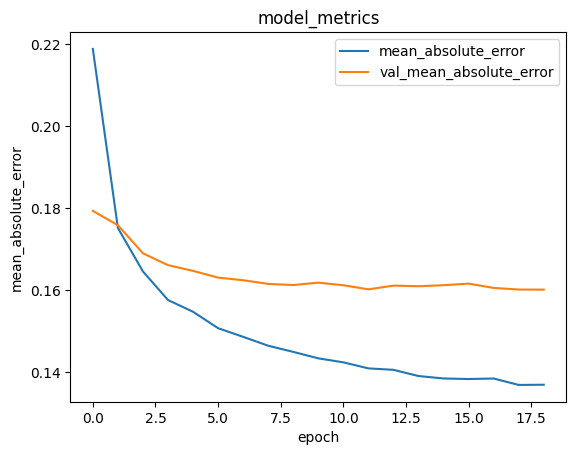

In [ ]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model_metrics')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['mean_absolute_error', 'val_mean_absolute_error'])
plt.show()

Berdasarkan hasil `fitting` nilai konvergen metrik MAE berada sedikit dibawah 0.1374 untuk training dan sedikit diatas 0.1500 untuk validasi.

#### Root Mean Squared Error Plot

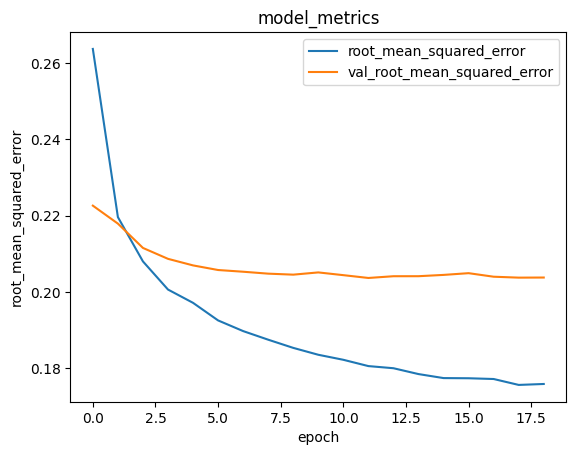

In [ ]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['root_mean_squared_error', 'val_root_mean_squared_error'])
plt.show()

Berdasarkan hasil fitting nilai konvergen metrik RMSE berada sedikit diatas 0.1760 untuk training dan sedikit dibawah 0.180 untuk validasi.